road_sign_generation

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader
import torch.optim as optim

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(f"Device: {device}")

Device: cuda:0


In [ ]:

!unzip trafic_32.zip
data_path = 'trafic_32'

In [92]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
batch_size = 32

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset = ImageFolder(data_path, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Number of images in training dataset: {len(train_dataset)}")
print(f"Number of images in validation dataset: {len(val_dataset)}")
print(f"Number of images in test dataset: {len(test_dataset)}")

Number of images in training dataset: 31367
Number of images in validation dataset: 3920
Number of images in test dataset: 3922


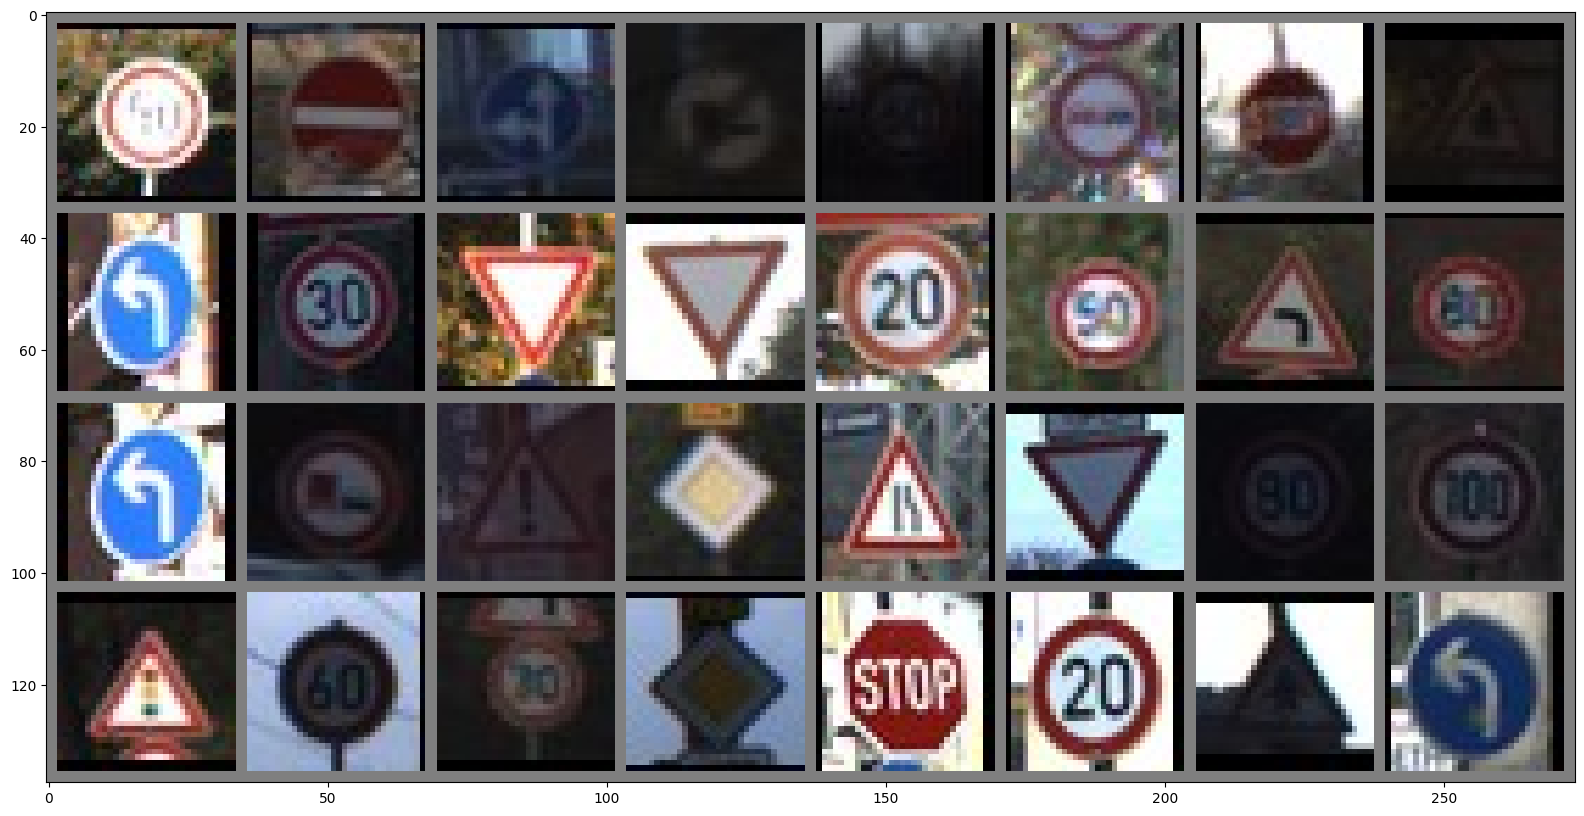

['00002', '00017', '00037', '00042', '00003', '00009', '00014', '00011', '00034', '00001', '00013', '00013', '00000', '00002', '00019', '00005', '00034', '00010', '00018', '00012', '00024', '00013', '00005', '00007', '00026', '00003', '00001', '00012', '00014', '00000', '00011', '00034']


In [5]:
plt.figure(figsize = (20,10))

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# get some random training images
images, labels = next(iter(train_loader))

# show images
imshow(torchvision.utils.make_grid(images))

print(list(dataset.classes[labels[j]] for j in range(batch_size)))

In [6]:
images.size()

torch.Size([32, 3, 32, 32])

## FID

In [74]:
class Evaluator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Evaluator, self).__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, 50)
        self.fc_out  = nn.Linear(50, n_classes)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def get_features(self, x):
        x = torch.flatten(x, 1)
        x = self.LeakyReLU(self.fc_1(x))
        x = self.LeakyReLU(self.fc_2(x))
        return x


    def forward(self, x):
        x = self.get_features(x)
        x = self.fc_out(x)
        return x

evaluator = Evaluator(32*32*3, 256).to(device)

In [76]:
# Optimizers
eval_optimizer = torch.optim.Adam(evaluator.parameters(), lr=0.001)
eval_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=eval_optimizer, gamma=0.97)

# loss
eval_criterion = nn.CrossEntropyLoss()

num_epochs = 10
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    for data, targets in iter(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        results = evaluator(data)
        loss = eval_criterion(results, targets)

        eval_optimizer.zero_grad()
        loss.backward()
        eval_optimizer.step()

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


In [77]:
######### Frechet Inception distance based on implementation from https://github.com/mseitzer/pytorch-fid

import numpy as np
from scipy import linalg


def calculate_frechet_distance(distribution_1, distribution_2, eps=1e-6):
    mu1 = np.mean(distribution_1, axis=0)
    sigma1 = np.cov(distribution_1, rowvar=False)

    mu2 = np.mean(distribution_2, axis=0)
    sigma2 = np.cov(distribution_2, rowvar=False)

    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    Stable version by Dougal J. Sutherland.
    Params:
    -- mu1   : Numpy array containing the activations of a layer of the
               inception net (like returned by the function 'get_predictions')
               for generated samples.
    -- mu2   : The sample mean over activations, precalculated on an
               representative data set.
    -- sigma1: The covariance matrix over activations for generated samples.
    -- sigma2: The covariance matrix over activations, precalculated on an
               representative data set.
    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

In [78]:
orig_data = [x[0] for x in list(test_dataset)[:1000]]
orig_data = torch.stack(orig_data)

dist_orig_data = evaluator.get_features(orig_data.to(device)).cpu()

## Generative Adversarial Networks


In [79]:
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_classes, embed_dim):
        super(Discriminator, self).__init__()

        self.label_embedding = nn.Embedding(n_classes, embed_dim)

        self.fc_1 = nn.Linear(input_dim + embed_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_out  = nn.Linear(hidden_dim, 1)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, image, labels):

        image = torch.flatten(image, 1)

        label_embedding = self.label_embedding(labels)
        combined_input = torch.cat((image, label_embedding), 1)

        x = self.LeakyReLU(self.fc_1(combined_input))
        x = self.LeakyReLU(self.fc_2(x))
        x = self.fc_out(x)
        return x

In [80]:
class Generator(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, n_classes, embed_dim):
        super(Generator, self).__init__()

        self.label_embedding = nn.Embedding(n_classes, embed_dim)

        self.fc_1 = nn.Linear(latent_dim + embed_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_3 = nn.Linear(hidden_dim, output_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, noise, labels):
        label_embedding = self.label_embedding(labels)

        combined_input = torch.cat((noise, label_embedding), 1)

        h = self.LeakyReLU(self.fc_1(combined_input))
        h = self.LeakyReLU(self.fc_2(h))

        x_hat = torch.tanh(self.fc_3(h))
        x_hat = x_hat.view([-1, 3, 32, 32])
        return x_hat

In [85]:
n_classes = len(dataset.classes)
# Models
latent_dim = 32
generator = Generator(latent_dim=latent_dim, hidden_dim=256, output_dim=3072, n_classes=n_classes, embed_dim=10).to(device)
discriminator = Discriminator( hidden_dim=256, input_dim=3072, n_classes=n_classes, embed_dim=10).to(device)

# Optimizers
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0001)
generator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=generator_optimizer, gamma=0.99)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0001)
discriminator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=discriminator_optimizer, gamma=0.99)

# loss
criterion = nn.MSELoss()

In [86]:
fixed_noise = torch.randn(16, latent_dim,device=device)
fixed_fake_labels = torch.randint(0, n_classes, (16,), device=device)

eval_fixed_noise = torch.randn(1000, latent_dim,device=device)
eval_fixed_fake_labels = torch.randint(0, n_classes, (1000,), device=device)

Epoch: 0, discrimiantor fake error: 0.227, discriminator real acc: 0.773
Epoch: 1, discrimiantor fake error: 0.229, discriminator real acc: 0.773
Epoch: 2, discrimiantor fake error: 0.238, discriminator real acc: 0.762
Epoch: 3, discrimiantor fake error: 0.234, discriminator real acc: 0.767
Epoch: 4, discrimiantor fake error: 0.242, discriminator real acc: 0.759
Epoch: 5, discrimiantor fake error: 0.233, discriminator real acc: 0.769
Epoch: 6, discrimiantor fake error: 0.228, discriminator real acc: 0.77
Epoch: 7, discrimiantor fake error: 0.22, discriminator real acc: 0.78
Epoch: 8, discrimiantor fake error: 0.226, discriminator real acc: 0.774
Epoch: 9, discrimiantor fake error: 0.233, discriminator real acc: 0.765


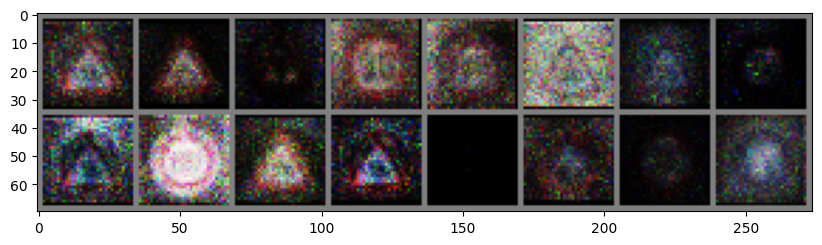

FID: 4255.855189479851


RuntimeError: Parent directory content/drive/MyDrive/ssne does not exist.

In [91]:
G_losses = []
D_losses = []
num_epochs = 100
for epoch in range(num_epochs):
    # For each batch in the dataloader
    discriminator_fake_acc = []
    discriminator_real_acc = []
    for i, data in enumerate(train_loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        discriminator_optimizer.zero_grad()
        # Format batch
        real_images = data[0].to(device)
        real_labels = data[1].to(device)
        b_size = real_images.size(0)
        label = torch.ones((b_size,), dtype=torch.float, device=device) # Setting labels for real images
        # Forward pass real batch through D
        output = discriminator(real_images, real_labels).view(-1)
        # Calculate loss on all-real batch
        error_discriminator_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        discriminator_real_acc.append(output.mean().item())

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, latent_dim,device=device)
        fake_labels = torch.randint(0, n_classes, (b_size,), device=device)
        # Generate fake image batch with Generator
        fake_images = generator(noise, fake_labels)
        label_fake = torch.zeros((b_size,), dtype=torch.float, device=device)
        # Classify all fake batch with Discriminator
        output = discriminator(fake_images.detach(), fake_labels).view(-1)
        # Calculate D's loss on the all-fake batch
        error_discriminator_fake = criterion(output, label_fake)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        discriminator_fake_acc.append(output.mean().item())
        # Compute error of D as sum over the fake and the real batches
        error_discriminator = error_discriminator_real + error_discriminator_fake
        error_discriminator.backward()
        # Update D
        discriminator_optimizer.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        generator_optimizer.zero_grad()
        label = torch.ones((b_size,), dtype=torch.float, device=device)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = discriminator(fake_images, fake_labels).view(-1)
        # Calculate G's loss based on this output
        error_generator = criterion(output, label)
        # Calculate gradients for G
        error_generator.backward()
        D_G_z2 = output.mean().item()
        # Update G
        generator_optimizer.step()

        # Output training stats
        # Save Losses for plotting later
        G_losses.append(error_generator.item())
        D_losses.append(error_discriminator.item())

    print(f"Epoch: {epoch}, discrimiantor fake error: {np.mean(discriminator_fake_acc):.3}, discriminator real acc: {np.mean(discriminator_real_acc):.3}")
    generator_scheduler.step()
    discriminator_scheduler.step()
    if epoch % 10 == 9:
        with torch.no_grad():
            fake = generator(fixed_noise, fixed_fake_labels).detach().cpu()

        plt.figure(figsize=(10,10))
        imshow(torchvision.utils.make_grid(fake))

        with torch.no_grad():
            generations_gan = generator(eval_fixed_noise, eval_fixed_fake_labels)
            dist_gan = evaluator.get_features(generations_gan.to(device)).cpu()

            fid = calculate_frechet_distance(dist_orig_data.numpy(),dist_gan.numpy())

        print(f"FID: {fid}")

        torch.save(generator.state_dict(), f'content/drive/MyDrive/ssne/generator_weights(epoch_{epoch}_model_1_fid_{fid:.0f}).pth')
        torch.save(discriminator.state_dict(), f'content/drive/MyDrive/ssne/discriminator_weights(epoch_{epoch}_model_1_fid_{fid:.0f}).pth')





In [ ]:
with torch.no_grad():
    fake = generator(fixed_noise, fixed_fake_labels).detach().cpu()
plt.figure(figsize=(10,10))
imshow(torchvision.utils.make_grid(fake))

with torch.no_grad():
    generations_gan = generator(eval_fixed_noise, eval_fixed_fake_labels)
    dist_gan = evaluator.get_features(generations_gan.to(device)).cpu()

print(f"FID: {calculate_frechet_distance(dist_orig_data.numpy(),dist_gan.numpy())}")